In [1]:
import matplotlib.pyplot as plt
from numba import jit, cuda 
import pandas as pd
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap
import Dataloader as dl

c:\Users\RaChr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# Loads data and returns a list of sentences as specfies in Dataloader
sentences = dl.loaddata()

# Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")
model = AutoModel.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")

# Tokenize sentences
encoded_input = tokenizer(
    sentences, padding=True, truncation=True, max_length=128, return_tensors="pt"
)

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])

sentence_embeddings = sentence_embeddings.detach().numpy()

# Perform t-SNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_results = tsne.fit_transform(sentence_embeddings)

# PCA Prep
pca = PCA(n_components=2)
X_pca = pca.fit_transform(sentence_embeddings)

# Perform UMAP Prep
reducer = umap.UMAP()

X_umap = reducer.fit_transform(sentence_embeddings)

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Index sentences along with their embeddings
sentence_index = {}
for sentence, embedding in zip(sentences, sentence_embeddings):
    sentence_index[sentence] = embedding

def retrieve_answer(question, threshold=0.7):
    # Tokenize the question and compute its embedding
    encoded_question = tokenizer(question, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        question_output = model(**encoded_question)
    question_embedding = mean_pooling(question_output, encoded_question["attention_mask"]).numpy()

    # Reshape the question embedding to 2D array
    question_embedding = np.reshape(question_embedding, (1, -1))

    # Calculate cosine similarity between the question embedding and all sentence embeddings
    similarities = {}
    for sentence, embedding in sentence_index.items():
        # Reshape the sentence embedding to 2D array
        embedding = np.reshape(embedding, (1, -1))
        similarity = cosine_similarity(question_embedding, embedding)[0][0]
        similarities[sentence] = similarity

    # Find the most similar sentence
    most_similar_sentence = max(similarities, key=similarities.get)
    similarity_score = similarities[most_similar_sentence]

    # If similarity score is above the threshold, return the answer associated with the sentence
    if similarity_score >= threshold:
        return most_similar_sentence
    else:
        return "I'm sorry, I don't have an answer to that question."

# Example usage:
question = "Men forsikringsoplysningen, Anja, hvad er det, I tilbyder der?"
answer = retrieve_answer(question)
print(answer)

Some weights of the model checkpoint at KennethEnevoldsen/dfm-sentence-encoder-large were not used when initializing BertModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.transform.LayerNorm.bias', 'lm_head.transform.LayerNorm.weight', 'lm_head.transform.dense.bias', 'lm_head.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


('Men forsikringsoplysningen, Anja, hvad er det, I tilbyder der?', ' Vi er en del af Forsikring- og pensionsselskabernes brancheorganisation, og vi er en rådgivningstjeneste, hvor man kan ringe ind og stille spørgsmål til sine forsikringer. F.eks. hvis man har været ude for et uheld, eller hvis man står over for at købe en ny forsikring.  Men det er faktisk også et sted, hvor man kan få hjælp til at sammenligne priser og tægning på forskellige forsikringer. Vi har et værktøj, der hedder forsikringsguiden.dk, og der kan man simpelthen sammenligne en lang række forsikringer. Og man kan også få hjælp til ligesom at afklare, hvad er det for forsikringer, jeg reelt har behov for. Så vi er ikke et forsikringssatskab, men vi er en tjeneste, som ligesom hjælper dig til at træffe nogle valg.')


In [ ]:
import Dataloader as dl

sentences = dl.loaddata()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")
model = AutoModel.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")

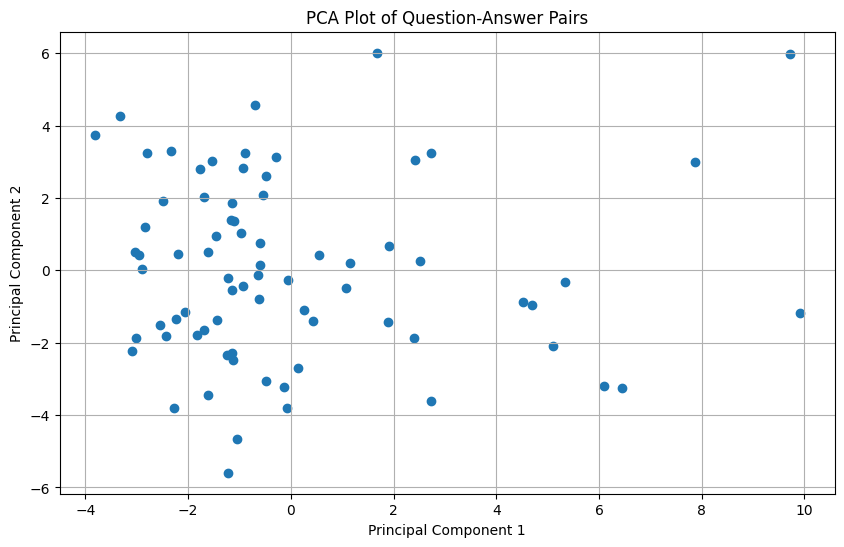

Text(0.5, 1.0, 'UMAP plot')

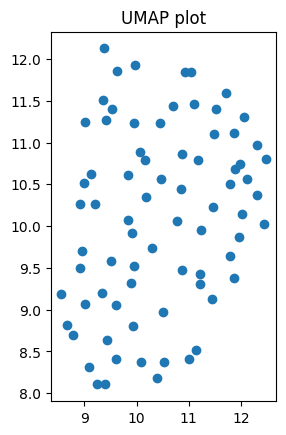

In [19]:
# Plot the results
# plt.scatter(tsne_results[:,0], tsne_results[:,1])
# plt.title('t-SNE of Sentence Embeddings')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.show()

# Plot PCA
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Question-Answer Pairs')
plt.grid(True)
plt.show()

# Plot UMAP
plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title('UMAP plot')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

In [ ]:
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
def answer_question(question, context):
    # Tokenize the input
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', max_length=512, truncation=True)

    # Get the model's predictions
    outputs = model(**inputs)

    # Get the start and end scores
    start_scores, end_scores = outputs.start_logits, outputs.end_logits

    # Get the start and end positions
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)

    # Get the answer
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_idx:end_idx+1]))

    return answer

context = 'insurance is a means of protection from financial loss. It is a form of risk management, primarily used to hedge against the risk of a contingent or uncertain loss. An entity which provides insurance is known as an insurer, an insurance company, an insurance carrier or an underwriter. A person or entity who buys insurance is known as an insured or as a policyholder. The insurance transaction involves the insured assuming a guaranteed and known relatively small loss in the form of payment to the insurer in exchange for the insurer is a promise to compensate the insured in the case of a financial loss. The insured receives a contract, called the insurance policy, which details the conditions and circumstances under which the insurer will compensate the insured. The amount of money charged by the insurer to the policyholder for the coverage set forth in the insurance policy is called the premium. If the insured experiences a loss which is potentially covered by the insurance policy, the insured submits a claim to the insurer for processing by a claims adjuster.'
question = "What is insurance?"
print(answer_question(question, context))

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Index sentences along with their embeddings
sentence_index = {}
for sentence, embedding in zip(sentences, sentence_embeddings):
    sentence_index[sentence] = embedding

def retrieve_answer(question, threshold=0.7):
    # Tokenize the question and compute its embedding
    encoded_question = tokenizer(question, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        question_output = model(**encoded_question)
    question_embedding = mean_pooling(question_output, encoded_question["attention_mask"]).numpy()

    # Reshape the question embedding to 2D array
    question_embedding = np.reshape(question_embedding, (1, -1))

    # Calculate cosine similarity between the question embedding and all sentence embeddings
    similarities = {}
    for sentence, embedding in sentence_index.items():
        # Reshape the sentence embedding to 2D array
        embedding = np.reshape(embedding, (1, -1))
        similarity = cosine_similarity(question_embedding, embedding)[0][0]
        similarities[sentence] = similarity

    # Find the most similar sentence
    most_similar_sentence = max(similarities, key=similarities.get)
    similarity_score = similarities[most_similar_sentence]

    # If similarity score is above the threshold, return the answer associated with the sentence
    if similarity_score >= threshold:
        return most_similar_sentence
    else:
        return "I'm sorry, I don't have an answer to that question."

# Example usage:
question = "I tilbyder der?"
answer = retrieve_answer(question)
print(answer)

I'm sorry, I don't have an answer to that question.


I'm sorry, I don't have an answer to that question.
